# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

# 1. Load Dataset

In [235]:
df = pd.read_csv('./data/total.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('Date', inplace=True)

In [1]:
df1 = pd.read_csv('./data/master2.csv')

NameError: name 'pd' is not defined

In [236]:
df['target'] = df['oversea_inflow'].diff()

In [380]:
# 일일 해외유입 확진자를 구할때 첫번째 로우는 NaN이기 때문에 0값을 넣어준다.
df['target'][0] = 0

# Data Exploration

In [238]:
# 결측치 확인
df.isnull().sum()

oversea_inflow    0
roam              0
g_confirmed       0
g_deaths          0
g_recovered       0
g_dayconfirmed    0
g_daydeaths       0
g_dayrecovered    0
k_confirmed       0
k_deaths          0
k_recoverd        0
k_dayconfirmed    0
k_day_osi_1       0
target            0
dtype: int64

In [385]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (59, 14)
target feature shape: (59,)


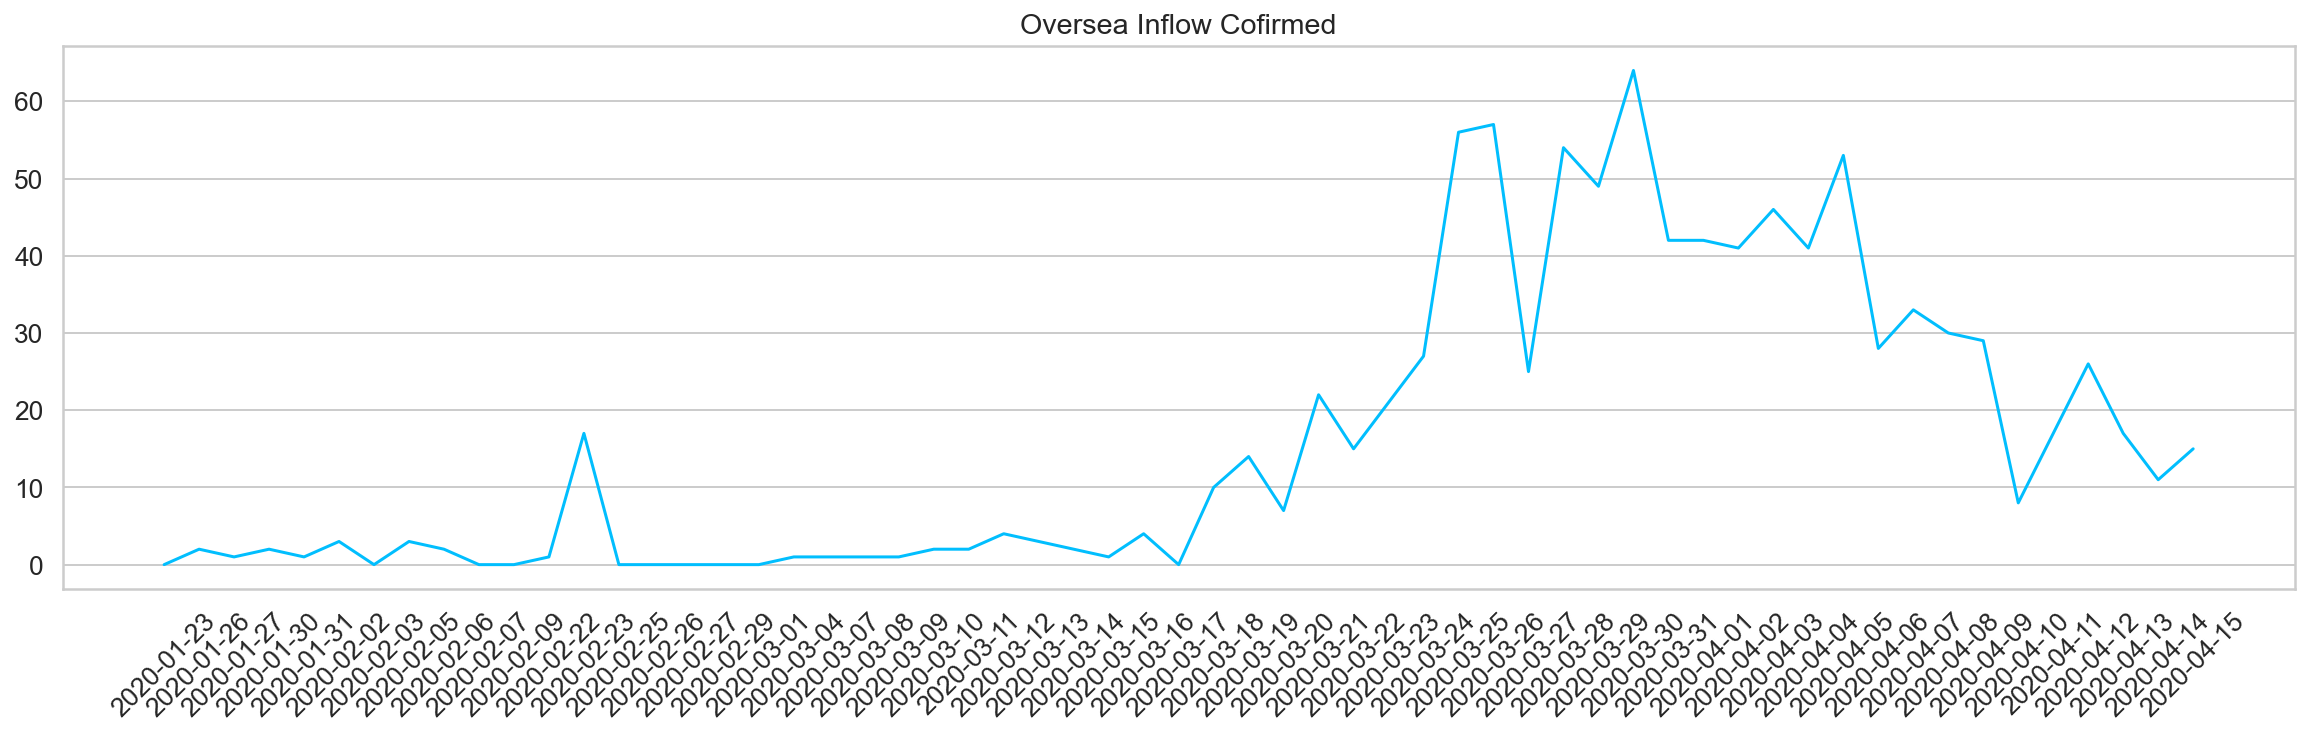

In [386]:
plt.figure(figsize=(20,5))
plt.plot(df['target'])
plt.xticks(rotation=45)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

In [387]:
# 테스트 데이터 수
test_data_size = 14

# X변수들과 y변수 구분
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [281]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [282]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (45, 13)
test set :  (14, 13)


In [283]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [284]:
# 시퀀스 길이
seq_length = 5

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [285]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [390]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([39, 5, 13])
X_test : torch.Size([8, 5, 13])
y_train : torch.Size([39, 5])
y_test : torch.Size([8, 5])


# Building a Model

In [288]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [290]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, )
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [327]:
# Hyper-parameter 설정
n_features=13
n_hidden=32
n_layers=3 
lr=1e-4
num_epochs=350

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.06241317093372345 test loss: 0.16279970109462738
Epoch 10 train loss: 0.06192164495587349 test loss: 0.15905369818210602
Epoch 20 train loss: 0.060033686459064484 test loss: 0.147912859916687
Epoch 30 train loss: 0.05920996889472008 test loss: 0.1443023979663849
Epoch 40 train loss: 0.058730531483888626 test loss: 0.14507080614566803
Epoch 50 train loss: 0.059131722897291183 test loss: 0.1367892324924469
Epoch 60 train loss: 0.058877065777778625 test loss: 0.1322973370552063
Epoch 70 train loss: 0.058521244674921036 test loss: 0.14026063680648804
Epoch 80 train loss: 0.05690518394112587 test loss: 0.13866537809371948
Epoch 90 train loss: 0.060385145246982574 test loss: 0.1405963897705078
Epoch 100 train loss: 0.05859464779496193 test loss: 0.13345928490161896
Epoch 110 train loss: 0.05734313279390335 test loss: 0.13386598229408264
Epoch 120 train loss: 0.05688375234603882 test loss: 0.12768927216529846
Epoch 130 train loss: 0.05603624880313873 test loss: 0.1264318

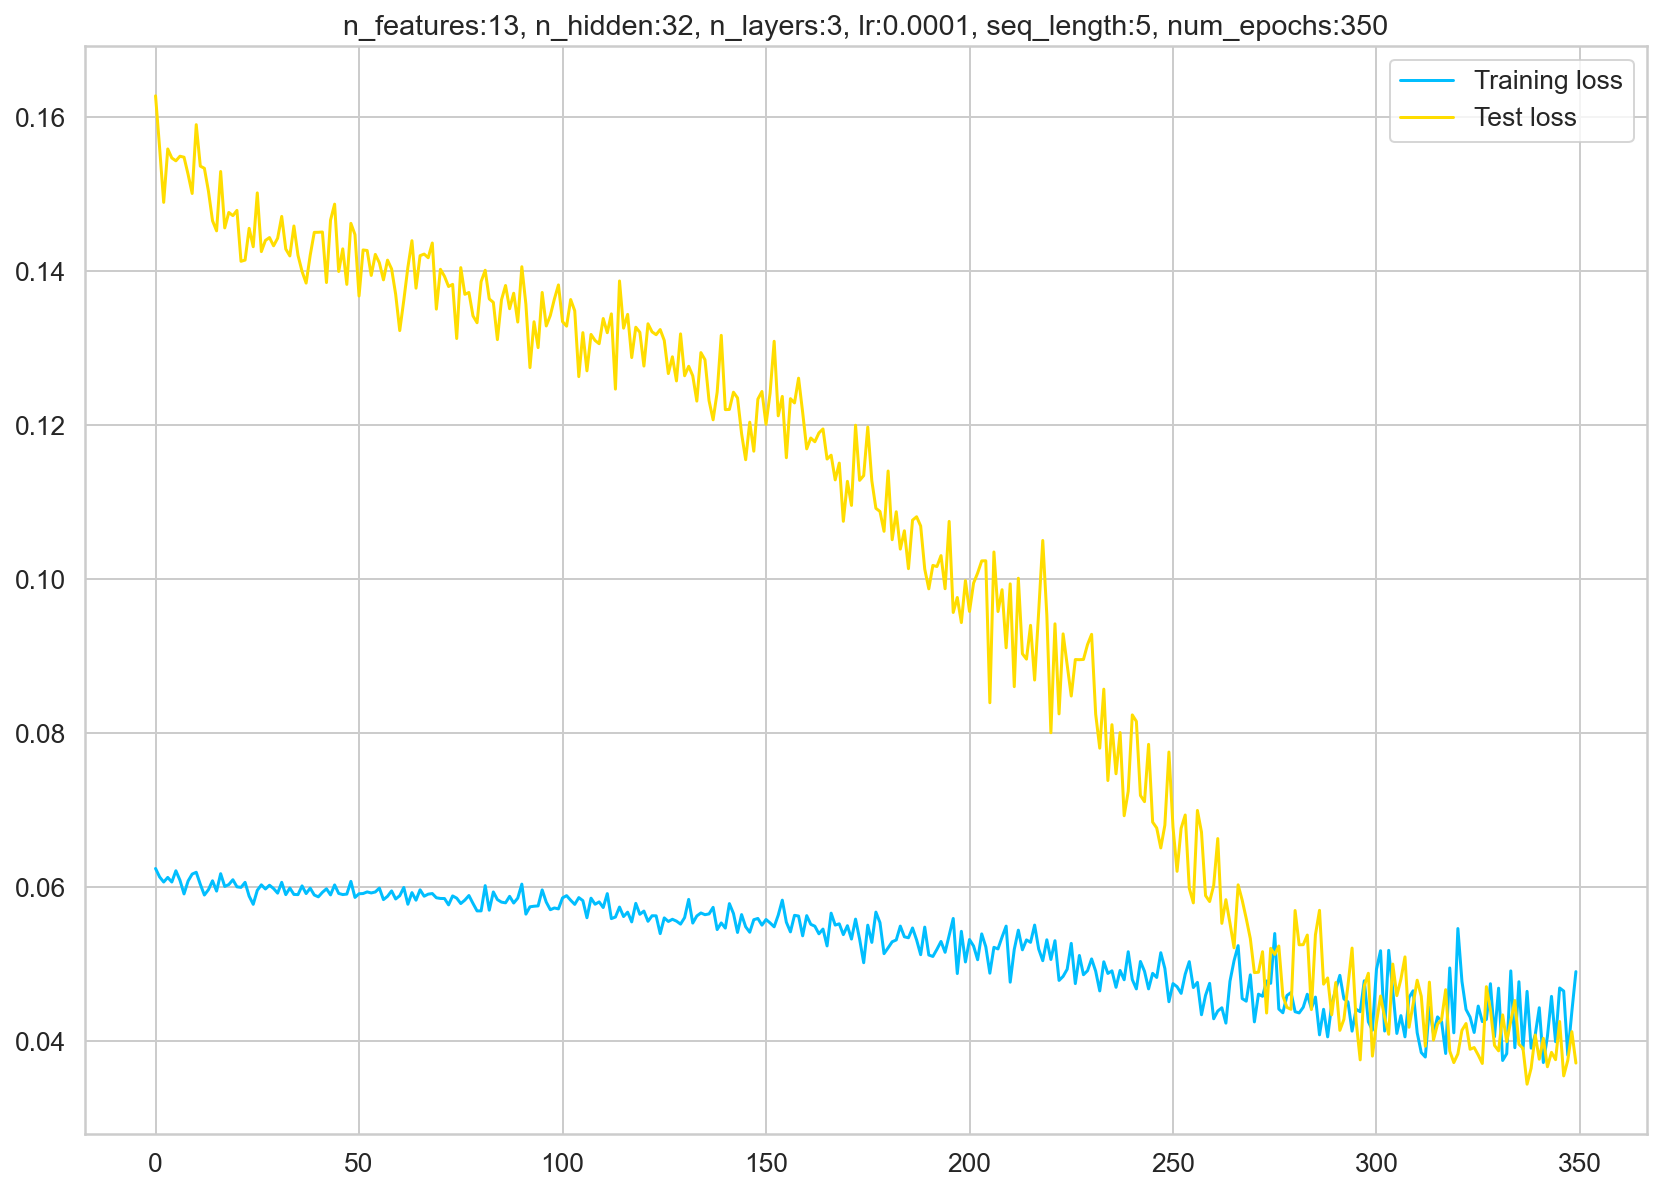

In [328]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [338]:
# 모델 저장
torch.save(model.state_dict(), './models/LSTM_1.pth')
# 모델 불러오기
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model.load_state_dict(torch.load('./models/LSTM_1.pth'))
model.eval()

<All keys matched successfully>

# Predicting daily cases

In [339]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [340]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [341]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
pred_values_ceiled

[33, 33, 33, 34, 34, 34, 34, 33]

In [366]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [377]:
# validation score
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

72.74939172749392

In [378]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

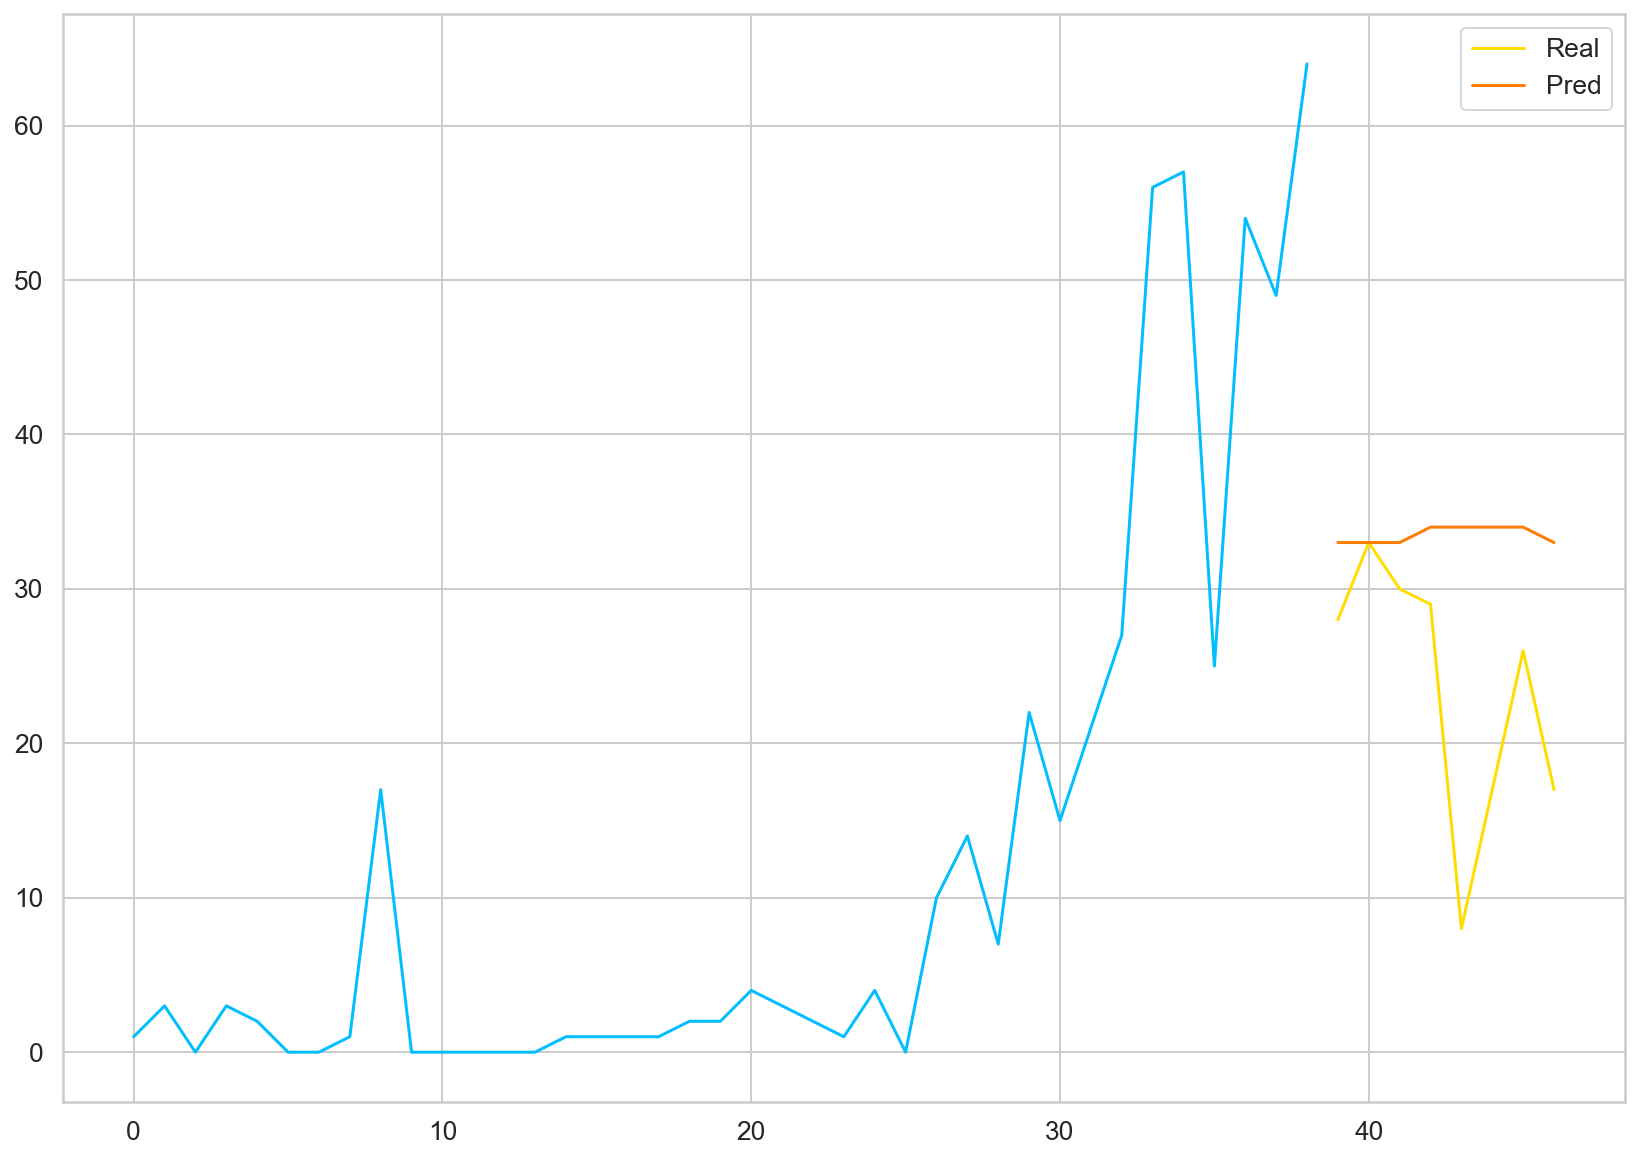

In [379]:
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
plt.legend()

# Use all data for training

In [329]:
scaler = MinMaxScaler()
scaler = scaler.fit(df)
all_data = scaler.transform(df)
all_data.shape

(59, 14)

In [337]:
X_all = create_sequences1(all_data[:-1], seq_length)
y_all = create_sequences1(all_data[-1], seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [339]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, lr)

Epoch 0 train loss: 0.13578762114048004 test loss: 0.4018231928348541
Epoch 10 train loss: 0.07324376702308655 test loss: 0.2234727144241333
Epoch 20 train loss: 0.06446003168821335 test loss: 0.09423962235450745
Epoch 30 train loss: 0.05813935399055481 test loss: 0.13833077251911163
Epoch 40 train loss: 0.05976434051990509 test loss: 0.14829684793949127
Epoch 50 train loss: 0.0575072206556797 test loss: 0.10224224627017975
Epoch 60 train loss: 0.051992785185575485 test loss: 0.07844400405883789
Epoch 70 train loss: 0.05019085109233856 test loss: 0.03995053097605705
Epoch 80 train loss: 0.036713432520627975 test loss: 0.0513826422393322
Epoch 90 train loss: 0.035342682152986526 test loss: 0.20912142097949982
Epoch 100 train loss: 0.03283043950796127 test loss: 0.2755965292453766
Epoch 110 train loss: 0.027378438040614128 test loss: 0.2905181646347046
Epoch 120 train loss: 0.0330442450940609 test loss: 0.3087272644042969
Epoch 130 train loss: 0.031239096075296402 test loss: 0.3455989360

# Predicting future cases

In [ ]:
DAYS_TO_PREDICT = 14

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

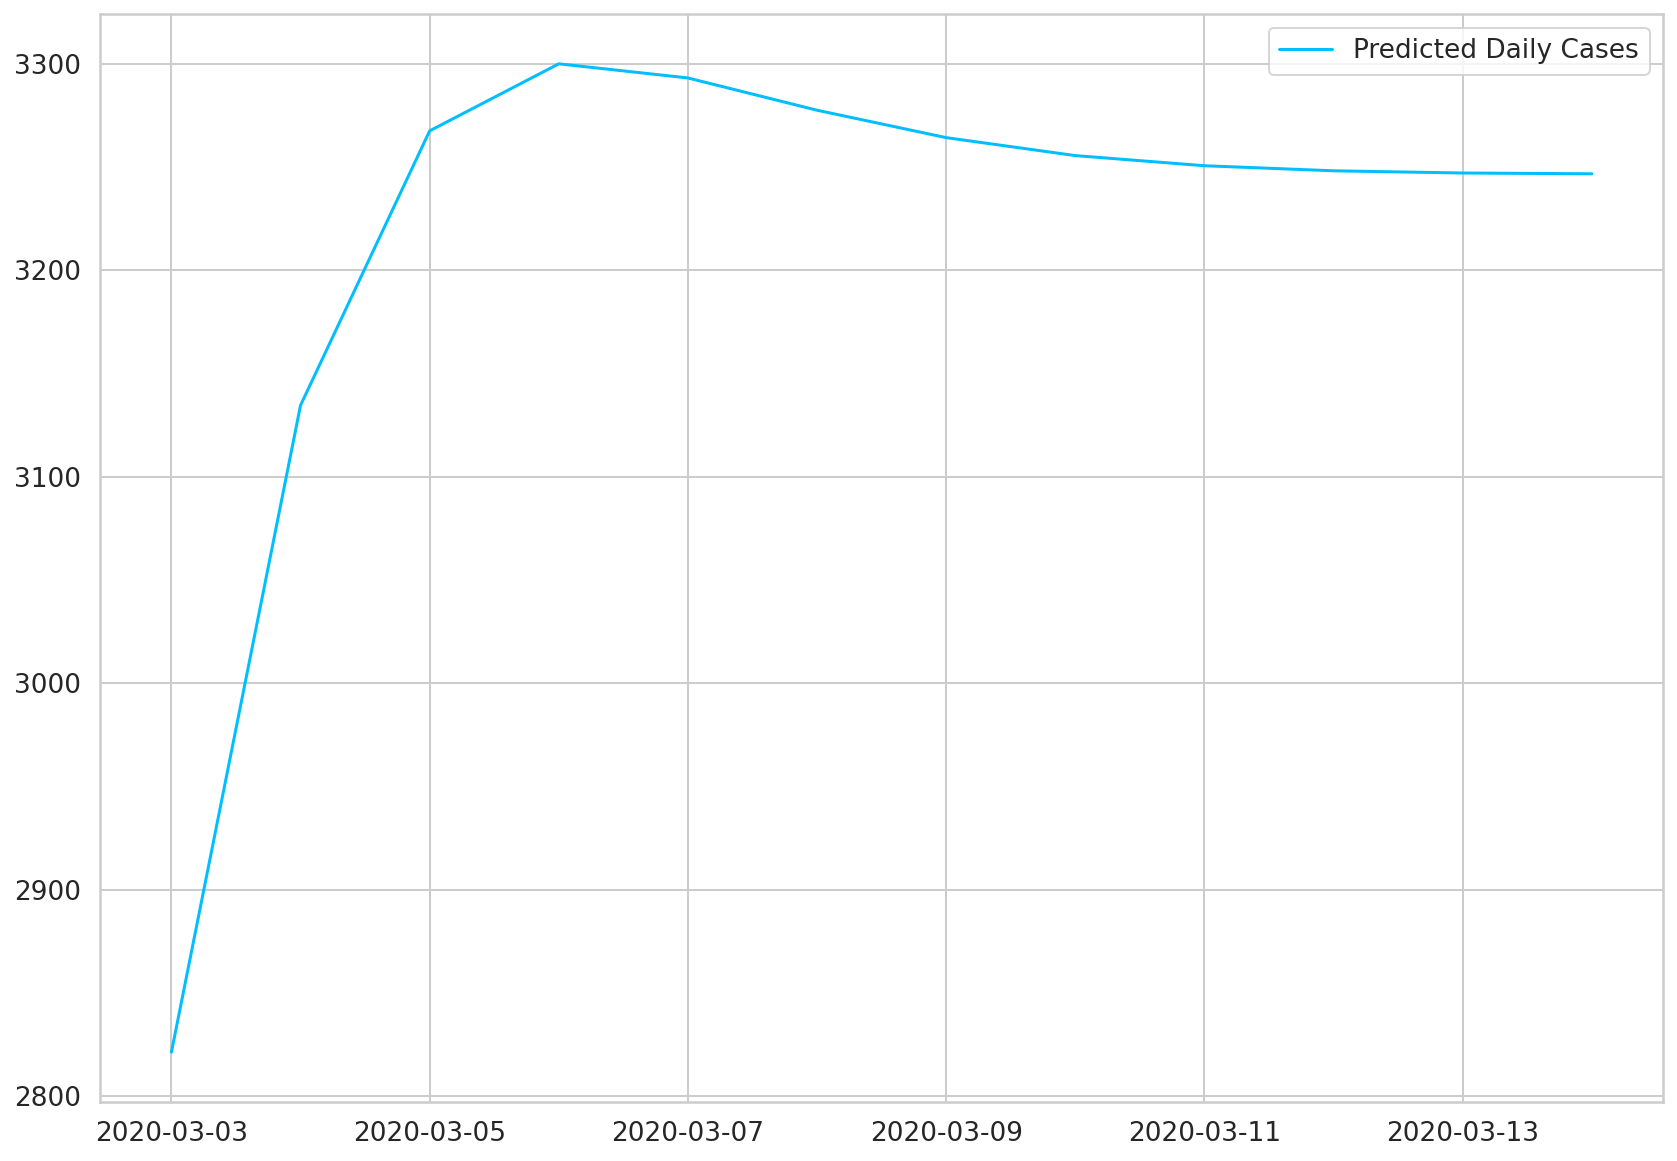

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

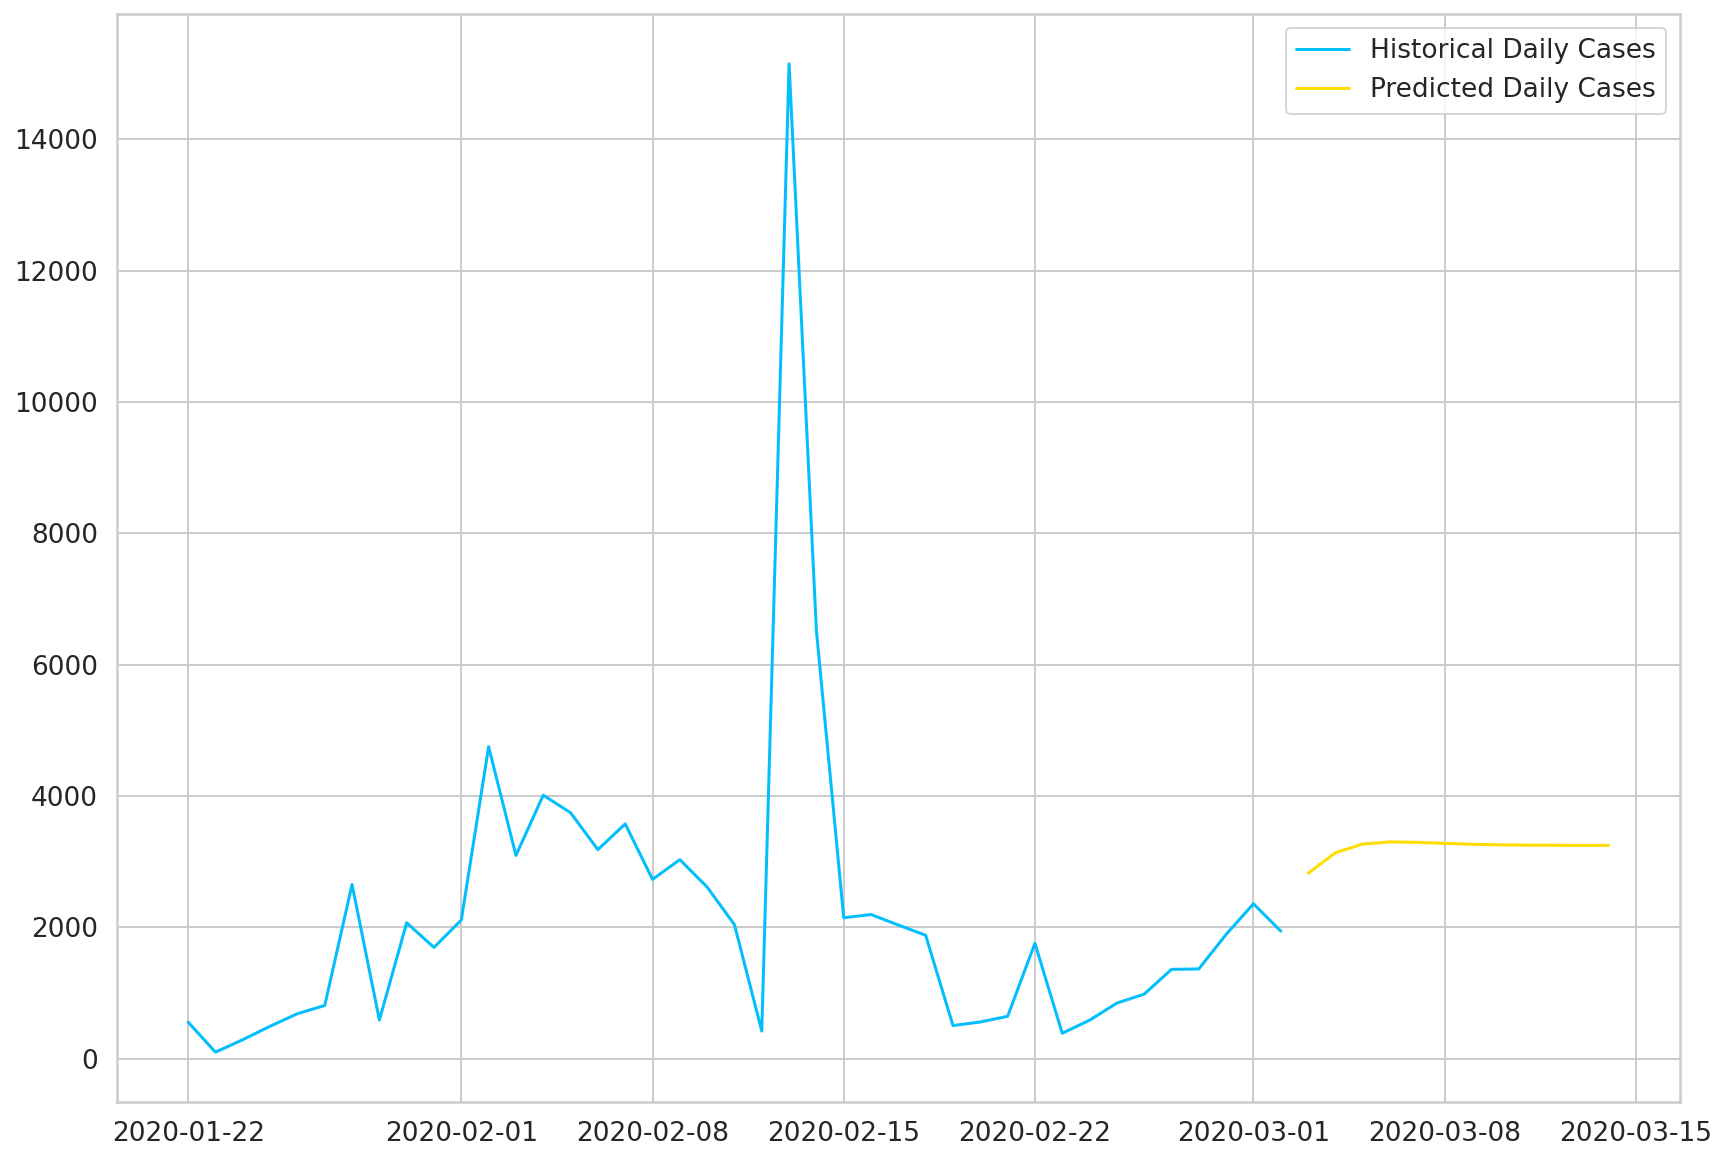

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();